### **1. import module**
* 다 사용하지는 않음

In [ ]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob, pickle
import os
import warnings
warnings.filterwarnings("ignore")
# 경고메세지 생략, 오류메세지만 나오도록함.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Attention, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
#import tensorflow_addons as tfa
import tensorflow as tf

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

### **2. 실제 모델 만들기 전 test**

**2.1. 이미지 불러오기**

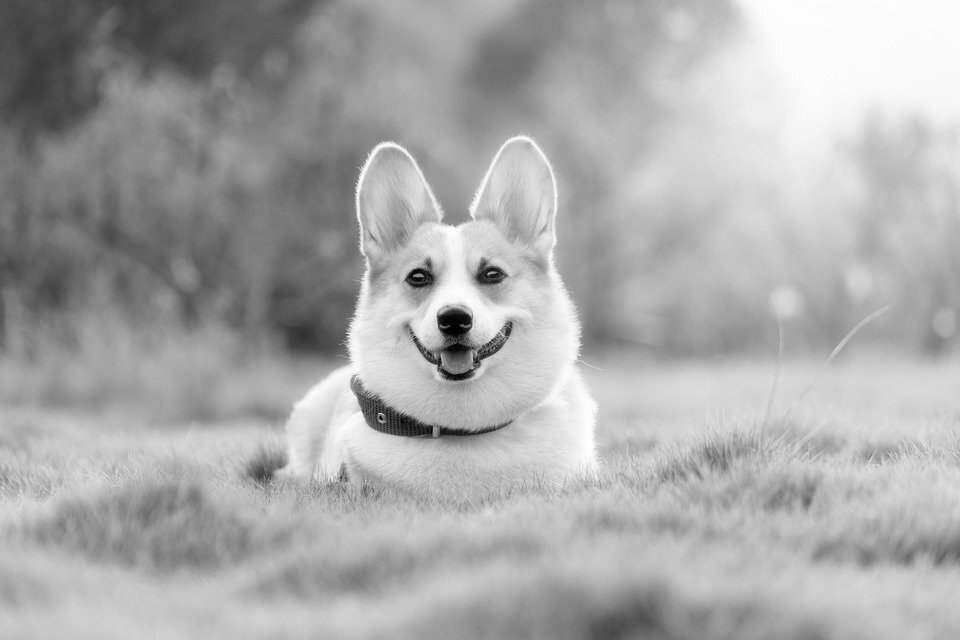

In [ ]:
img_dir = "/content/drive/MyDrive/audio_project/dog_image.jpeg"
img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

**2.2. 이미지 resize**

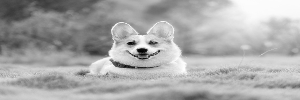

(100, 300)


In [ ]:
resize_img = cv2.resize(img, (300,100))
cv2_imshow(resize_img)
print(resize_img.shape)

**2.3. 차원 변환**
* tf.image.extract_patches 가 4차원의 input을 바라기에 차원을 늘려주어야 한다. (batch_size, height, width, channel)

In [ ]:
resize_img = np.expand_dims(resize_img,-1)
resize_img = np.expand_dims(resize_img,0)
print(resize_img.shape)

(1, 100, 300, 1)


**2.4. patches 코드 정의 및 실행**
* https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

In [ ]:
image_size = (100,300,1)

width_len = 10
height_len = 100 # n_mels와 같음
patch_size = (height_len, width_len) # (100,10)
num_patches = (image_size[1]//patch_size[1]) # 300//10 = 30

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]  # 입력 이미지의 배치 크기를 가져옴

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],  # 추출할 패치의 크기
            strides=[1, self.patch_size[0], self.patch_size[1], 1],  # 패치 윈도우의 이동 간격
            rates=[1, 1, 1, 1],  # 패치 추출 시 각 차원에서의 확장 비율
            padding="VALID",  # 패치가 이미지 안에 완전히 들어갈 수 있는 위치에서만 추출
        )
        # 현재 결과 (1,1,30,1000) -> 1000개의 값을 reshape해서 (100,10)으로 만들면 원래 이미지가 보인다.
        patch_dims = patches.shape[-1]  # 추출된 패치의 마지막 차원 크기를 가져옴

        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # 추출된 패치들을 2D 텐서로 변형합니다.

        return patches  # 추출된 패치들을 반환


**2.5. 실행결과 확인**

In [ ]:
patches = Patches(patch_size)(resize_img)
print(patches.shape)

(1, 30, 1000)


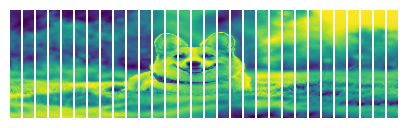

In [ ]:
plt.figure(figsize = (5,20))
div_len = int(patches.shape[1]) # div_len = 30, 정확히는 num_patches와 동일, 한줄로 나눠서

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(1,div_len,i+1) # 1부터 30까지 30 포함.
    patch_img = tf.reshape(patch, (patch_size[0], patch_size[1],1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**2.6. 위치 정보 추가**
* 원래 논문에서는 positional encoding을 sin, cos함수로 정의했다.
* 최근에는 embedding layer를 만들어 위치정보 또한 딥러닝이 학습하는 방식을 사용한다.
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
projection_dim = 256
PatchEncoder(num_patches, projection_dim)(patches)

<tf.Tensor: shape=(1, 30, 256), dtype=float32, numpy=
array([[[-361.68784  , -100.44794  ,  -21.338335 , ...,  105.99306  ,
          -39.324284 ,    3.2155693],
        [-349.11075  , -124.80959  ,  -42.41688  , ...,  106.81843  ,
          -53.080925 ,    7.1527452],
        [-381.28232  , -115.35528  , -122.16825  , ...,  131.83714  ,
          -36.06716  ,   18.236582 ],
        ...,
        [-459.59186  ,   38.85904  , -119.73016  , ...,  299.95172  ,
         -152.88591  ,  -27.044716 ],
        [-464.2317   ,   19.692772 , -119.35907  , ...,  307.67578  ,
         -157.71016  ,    2.155796 ],
        [-481.00085  ,   27.589634 , -103.99867  , ...,  341.01022  ,
         -151.4379   ,   19.692226 ]]], dtype=float32)>

**예시모델 구축**
* 잘 compile 되는지 확인.
* multihead attention 관련 참고 자료
* https://tkayyoo.tistory.com/135
* https://wikidocs.net/162098
* https://csm-kr.tistory.com/54

아래 2개 사이트 추천